In [4]:
import numpy as np
import pandas as pd
import pytrends
import yfinance as yf
import time
import matplotlib.pyplot as plt
from pytrends import dailydata
from pytrends.exceptions import TooManyRequestsError

This notebook generates fundamental and speculative information regarding Bitcoin through scraping and there is a dataset that has been manually downloaded and curated outside of this notebook.
Inputs: 
- __"CryptoInfo.csv"__ = Simple download from https://coinmetrics.io has been performed to variables mentined in the core body of the thesis regarding Bitcoin's fundamental metrics

Output:
- __"GoogleBTC.csv"__ = Dataset depicting the popularity of term "Bitcoin" within Google search
- __"GoogleCrypto.csv"__ = Dataset depicting the popularity of term "Cryptocurrecy" within Google search
- __"yfdata.csv"__ = Information regarding S&P500, VIX and EUR/USD stocks

## Google Trends Dataset
Following lines download the Google Trends information regarding both the currency (Bitcoin) and the overall market (Cryptocurrency) search frequency for the exact keyword mentioned in brackets.

In [2]:
keywords = ["Bitcoin", "Cryptocurrency"]
s_year = 2017
s_mon = 12
e_year = 2021
e_mon = 10
geo = "US"

def get_data_with_backoff(word, max_retries=5):
    wait_time = 1.0  # start with 1 second
    retries = 0
    
    while retries < max_retries:
        try:
            data = dailydata.get_daily_data(word=word,
                                            start_year=s_year,
                                            start_mon=s_mon,
                                            stop_year=e_year,
                                            stop_mon=e_mon,
                                            geo=geo,
                                            verbose=False,
                                            wait_time=wait_time)
            return data
        except TooManyRequestsError:
            retries += 1
            wait_time *= 2  # double the wait time
            time.sleep(wait_time)

    raise Exception("Max retries reached")

dailydata1 = get_data_with_backoff(keywords[0])
dailydata2 = get_data_with_backoff(keywords[1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


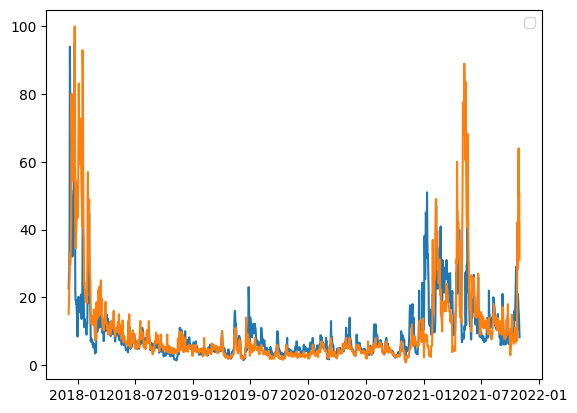

In [5]:
plt.plot(dailydata1["Bitcoin"])
plt.plot(dailydata2["Cryptocurrency"])
plt.legend()
plt.show()

In [6]:
# Cleaning up the data for redundant observations
GoogleBTC = dailydata1["Bitcoin"][("2018-01-01" <= dailydata1["Bitcoin"].index) & (dailydata1["Bitcoin"].index <= "2021-09-21")]
#GoogleBTC.to_csv('GoogleBitcoin.csv',index=False)
GoogleBTC

date
2018-01-01    15.12
2018-01-02    19.74
2018-01-03    20.16
2018-01-04    18.06
2018-01-05    18.48
              ...  
2021-09-17     6.15
2021-09-18     6.15
2021-09-19     7.03
2021-09-20    11.21
2021-09-21    11.97
Name: Bitcoin, Length: 1360, dtype: float64

In [7]:
GoogleCrypto = dailydata2["Cryptocurrency"][("2018-01-01" <= dailydata2["Cryptocurrency"].index) & (dailydata2["Cryptocurrency"].index <= "2021-09-21")]
#GoogleCrypto.to_csv('GoogleCrypto.csv',index=False)
GoogleCrypto

date
2018-01-01    43.56
2018-01-02    51.48
2018-01-03    70.29
2018-01-04    83.16
2018-01-05    72.27
              ...  
2021-09-17     8.70
2021-09-18     8.10
2021-09-19     9.18
2021-09-20    13.50
2021-09-21    11.70
Name: Cryptocurrency, Length: 1360, dtype: float64

## Yahoo! Finance Data
In following cells, we are going to download VIX and S&P500 values, together with EUR/USD exchange rate to be used further on.

In [8]:
# Defining the data and dates
tickers = ["^GSPC", "^VIX", "EURUSD=X"]
start_date = "2017-12-31"
end_date = "2021-09-22"

# Fetching the data
yfdata = yf.download(tickers, start=start_date, end=end_date)

# Separating into close and open prices in order to extract the logrets
close = yfdata["Close"]
opn = yfdata["Open"]

yfsplogrets = np.log(close["^GSPC"]/opn["^GSPC"]).to_frame()
yfexchlogrets = np.log(close["EURUSD=X"] / opn["EURUSD=X"]).to_frame()

yfdata = yfsplogrets.join(yfexchlogrets).join(close["^VIX"])
yfdata.columns = [ "SP500Lret", "EURUSDLret", "VIX"]
yfdata = yfdata[["EURUSDLret", "SP500Lret", "VIX"]]
#yfdata.to_csv("yfdata.csv")
yfdata.head()

[*********************100%%**********************]  3 of 3 completed


,EURUSDLret,SP500Lret,VIX
Date,,,
2018-01-01,0.000000,NaN,NaN
2018-01-02,0.000060,0.004491,9.77
2018-01-03,0.000121,0.005622,9.15
2018-01-04,-0.000072,0.001720,9.22
2018-01-05,0.000217,0.004318,9.22


## Technical information about Bitcoin

In [9]:
CryptoInfo = pd.read_csv("CryptoInfo.csv", sep =";")
CryptoInfo

,Time,"BTC / Price, USD","BTC / Addresses, active, count","BTC / Hash rate, mean","BTC / Fees, transaction, mean, USD","BTC / Issuance, continuous, percent, annualized","BTC / NVT, adjusted"
0,2017-09-27,"4207,787485",702387,"8063002,609","2,354493117","4,042575657","41,16822984"
1,2017-09-28,"4187,769796",753933,"9708513,346","2,04600836","4,866942048","39,41164003"
2,2017-09-29,"4155,01012",741184,"9269710,483","1,8679664","4,646375717","40,94265089"
3,2017-09-30,"4334,544613",631821,"7569349,388","2,088460914","3,793687602","52,93359424"
4,2017-10-01,"4382,086898",628817,"7133598,092","2,557727961","3,573413805","55,09593341"
...,...,...,...,...,...,...,...
1556,2021-12-31,"46355,11733",1093396,"179781040,7","3,101157349","1,796918032","52,74821452"
1557,2022-01-01,"47560,00938",695722,"207532476,1","2,324257658","2,074176777","192,2345348"
1558,2022-01-02,"47352,55776",734444,"190640298,2","2,23030547","1,905248973","141,4961383"
1559,2022-01-03,"46453,43235",948843,"168921783,1","2,309664657","1,688117189","63,5880576"
